In [206]:
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [207]:
k,gamma,D = 1.0,1.0,1.0
delta_t=0.01
ampl = np.sqrt(2*D*delta_t)
N=2000

In [208]:
# random force
w=np.random.normal(0,1,N)

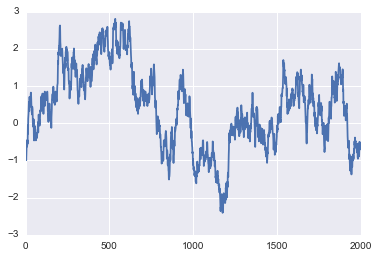

In [209]:
# differential equation x_i = x_(i-1) - k/gamma*x_(i-1) + sqrt(2*D*delta_t)*w_i
from itertools import accumulate
def next_point(x,y):
    return x - k/gamma*x*delta_t + ampl*y

x = np.fromiter(accumulate(w, next_point),np.float)
plt.plot(x)

In [210]:
print("std: ",x.std(),"mean: ",x.mean())

std:  1.06055288651 mean:  0.402683722403


In [211]:
# see http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.fftconvolve.html
from scipy import signal
autocorr = signal.fftconvolve(x, x[::-1], mode='full')

3999


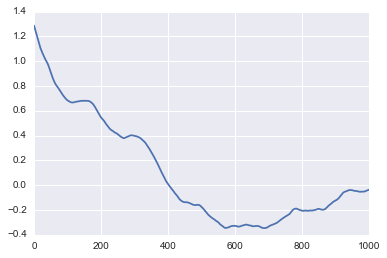

In [212]:
n=len(autocorr)
print(n)
autocorr=autocorr[int((n-1)/2):]*2.0/(n+1)
plt.plot(autocorr[:1000])

1000


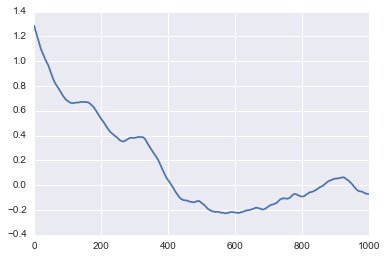

In [213]:
f=np.fft.rfft(x)
a=np.fft.irfft(f*np.conjugate(f))
a=np.fft.fftshift(a)/2000
print(len(a[1000:]))
plt.plot(a[1000:])

In [214]:
import lmfit as lm

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 8.847
    reduced chi-square = 0.018
    Akaike info crit   = -2011.278
    Bayesian info crit = -2002.849
[[Variables]]
    amplitude:   1.25058209 +/- 0.019582 (1.57%) (init= 1.416139)
    decay:       195.129006 +/- 4.590809 (2.35%) (init= 174.7133)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.724 



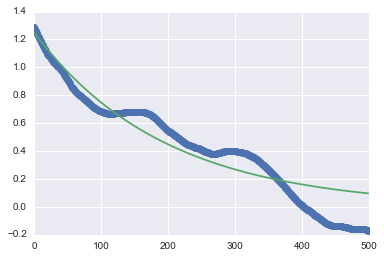

In [215]:
from lmfit.models import ExponentialModel

mod = ExponentialModel()
y = autocorr[:500]
t = np.arange(500)

pars = mod.guess(y, x=t)
out  = mod.fit(y, pars, x=t)
print(out.fit_report(min_correl=0.25))

plt.plot(t,y,"o")
plt.plot(t,out.best_fit)

In [216]:
# now lets model this data using pymc
#import pymc as pm

In [217]:
# define the model/function to be fitted.
def model(x): 
    t = pm.Uniform('t', 0.1, 20, value=2.0)
    A = pm.Uniform('A', 0.1, 10, value=1.0)
    
    @pm.deterministic(plot=False)
    def S(t=t):
        return 1-np.exp(-4*delta_t/t)
    
    @pm.deterministic(plot=False)
    def s(t=t):
        return np.exp(-2*delta_t/t)
        
    path = np.empty(N, dtype=object)
    
    path[0]=pm.Normal('path_0',mu=0, tau=1/A, value=x[0], observed=True)
    for i in range(1,N):
        path[i] = pm.Normal('path_%i' % i,
                            mu=path[i-1]*s,
                            tau=1/A/S,
                            value=x[i],
                            observed=True)
    return locals()

#mcmc = pm.MCMC( model(x) )
#mcmc.sample( 20000, 2000, 10 )

In [218]:
#pm.Matplot.plot(mcmc)

In [219]:
#mcmc.summary()